### Import Libraries

In [151]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 
import seaborn as sns

# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Load Data

In [152]:
df = pd.read_csv('./Assets/Datasets/Telco_Customer.csv')

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  Churn Label                   7043 non-null   object 
 13  Lon

In [154]:
df.shape

(7043, 16)

In [155]:
df.describe()

,Customer ID,Tenure Months,Monthly Purchase (Thou. IDR),Longitude,Latitude,CLTV (Predicted Thou. IDR)
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3521.000000,32.371149,84.190200,107.043249,-6.404182,5720.384481
std,2033.283305,24.559481,39.117061,0.358314,0.322896,1537.974298
min,0.000000,0.000000,23.725000,106.816670,-6.914740,2603.900000
25%,1760.500000,9.000000,46.150000,106.816670,-6.914740,4509.700000
50%,3521.000000,29.000000,91.455000,106.816670,-6.200000,5885.100000
75%,5281.500000,55.000000,116.805000,107.609810,-6.200000,6994.650000
max,7042.000000,72.000000,154.375000,107.609810,-6.200000,8450.000000


#### Dropping Unnecessary Column

In [156]:
df = df.drop(['Customer ID', 'Longitude', 'Latitude'], axis=1)

In [157]:
df.head(3)

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,CLTV (Predicted Thou. IDR)
0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,4210.7
1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,3511.3
2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,6983.6


#### Checking the unique values 

In [158]:
columns = ['Location', 'Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp', 'Payment Method', 'Churn Label']

for column in columns:
    print(df[column].unique())

['Jakarta' 'Bandung']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Digital Wallet' 'Pulsa' 'Debit' 'Credit']
['Yes' 'No']


In [159]:
columns_replace_val = ['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']

for column in columns_replace_val:
    df[column] = df[column].replace(['No internet service'], 'No')

#### Encoding

In [160]:
columns=['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp', 'Call Center', 'Churn Label', 'Location', 'Device Class', 'Payment Method']

le = LabelEncoder()

for column in columns:
    df[column] = le.fit_transform(df[column])

### Feature Selection

In [161]:
X = df.drop(['Churn Label'], axis=1)
y = df['Churn Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standarization

In [162]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)	

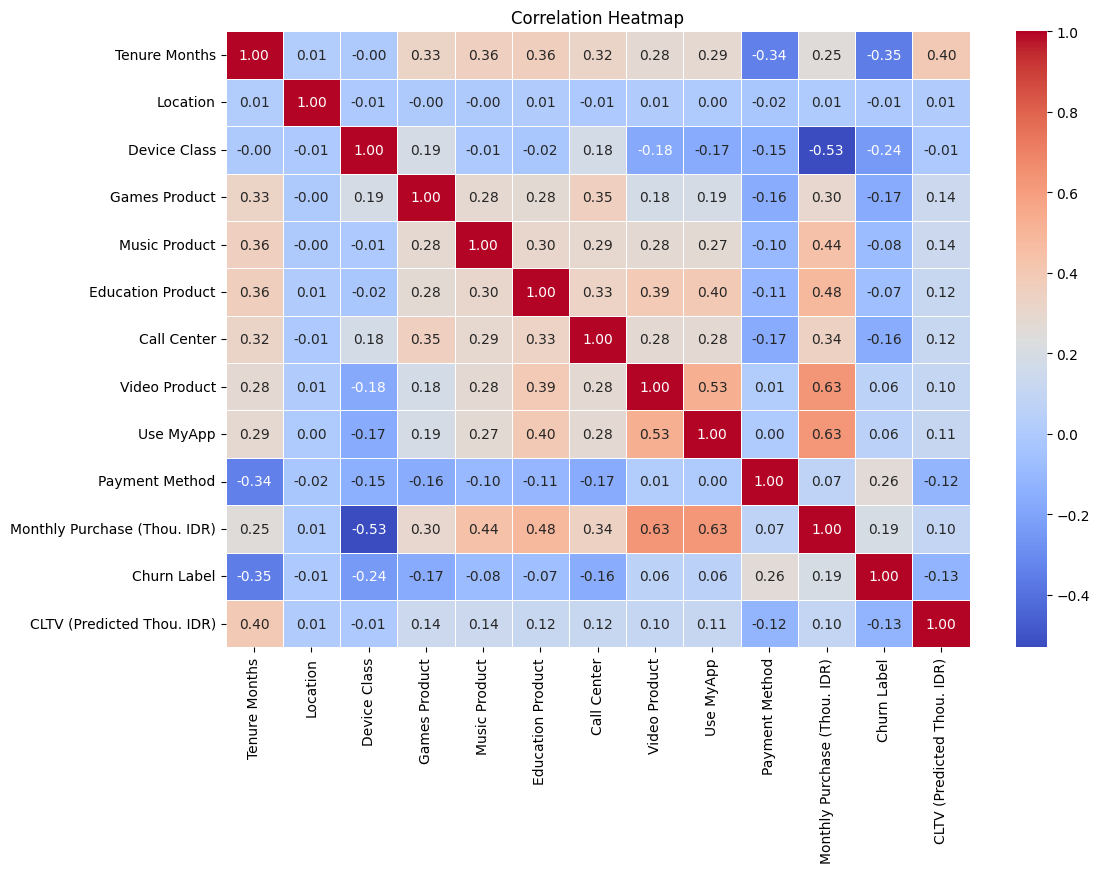

In [163]:
numerical_columns = df.select_dtypes(include=['number']).columns

# Calculating correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Creating a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Neural Network

In [164]:
model_NN = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_NN.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [165]:
model_NN.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

y_pred_nn = (model_NN.predict(X_test) > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(accuracy_nn)

Epoch 1/25
80/80 [==============================] - 2s 5ms/step - loss: 0.5816 - accuracy: 0.7179 - val_loss: 0.5132 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 2/25
80/80 [==============================] - 0s 3ms/step - loss: 0.4934 - accuracy: 0.7639 - val_loss: 0.4850 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 3/25
80/80 [==============================] - 0s 3ms/step - loss: 0.4840 - accuracy: 0.7686 - val_loss: 0.4680 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 4/25
80/80 [==============================] - 0s 3ms/step - loss: 0.4685 - accuracy: 0.7819 - val_loss: 0.4585 - val_accuracy: 0.7677 - lr: 0.0010
Epoch 5/25
80/80 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.7744 - val_loss: 0.4568 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 6/25
80/80 [==============================] - 0s 3ms/step - loss: 0.4574 - accuracy: 0.7813 - val_loss: 0.4491 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 7/25
80/80 [==============================] - 0s 3ms/step - loss: 0.4609 - a

In [166]:
y_pred_nn = (model_NN.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn:.2f}")

45/45 [==============================] - 0s 1ms/step
Neural Network Accuracy: 0.77
